# Analysis for Zeisel's 3005 mouse brain cells

Aftering obtaining a transcript compatibility count (TCC) distribution matrix by running the pipeline, we use the matrix to:

1. <a href='#section1'> Cluster cells </a>
2. <a href='#section2'> Determine the accuracy of clustering </a>
3. <a href='#section3'> Analyze Zeisel et al.'s Oligo1 cells </a>
4. <a href='#section4'> Take a closer look at Zeisel et al.'s Oligo3 cells </a>
5. <a href='#section5'> Analyze accuracy of clustering as the number of reads decreases </a>

We will show how we accomplish each of these below.

For the following analysis, we load in the obtained TCC pairwise distance matrix (3005-by-3005 matrix) and set of labels from the authors (271-by-1 vector).

In [1]:
import pickle
import numpy as np
with open('Zeisel_TCC_pairwise_JS_distance_subsample100_full.dat','rb') as infile:
    D = pickle.load(infile) 
labels9 = np.loadtxt('./Zeisels_data/Zeisels_labels9.txt',dtype=str).astype(int)-1

## Clustering  <a id='section1'></a>

Clustering was performed using both spectral clustering (when the number of clusters is known) and affinity propagation (when the number of clusters is unknown). First, a low-dimensional embedding of the data is obtained using the precomputed distances and t-SNE:

In [2]:
%%time
from sklearn import manifold
def tSNE_pairwise(D):
    tsne = manifold.TSNE(n_components=2, random_state=0, metric='precomputed', n_iter=2000, verbose=1);
    X_tsne = tsne.fit_transform(D);
    return X_tsne
X_tsne = tSNE_pairwise(D)

[t-SNE] Computed conditional probabilities for sample 1000 / 3005
[t-SNE] Computed conditional probabilities for sample 2000 / 3005
[t-SNE] Computed conditional probabilities for sample 3000 / 3005
[t-SNE] Computed conditional probabilities for sample 3005 / 3005
[t-SNE] Mean sigma: 0.082504
[t-SNE] Error after 65 iterations with early exaggeration: 22.858847
[t-SNE] Error after 141 iterations: 2.182714
CPU times: user 1min 23s, sys: 8.62 s, total: 1min 31s
Wall time: 1min 31s


We first visualize the data using t-SNE and the authors' 9 labels.

/home/govinda/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


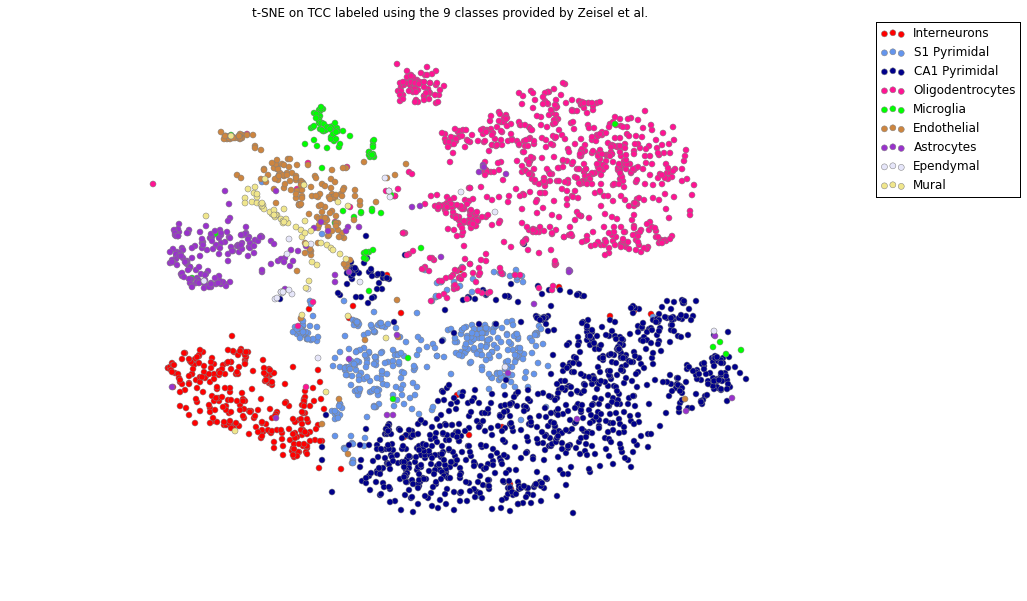

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
# Plot function with Zeisel's colors corresponding to labels 
def tru_plot9(X,labels):
    clust_names = ['Interneurons','S1 Pyrimidal','CA1 Pyrimidal','Oligodentrocytes',
                   'Microglia','Endothelial','Astrocytes','Ependymal','Mural']
    clust_color = ['red','cornflowerblue','darkblue','deeppink','lime',
                   'peru','darkorchid','lavender','khaki']
    unique_labels = np.unique(labels)
    plt.figure(figsize=(15,10))
    for i in unique_labels:
        ind = np.squeeze(labels == i)
        plt.scatter(X[ind,0],X[ind,1],c=clust_color[i],s=36,edgecolors='gray',
                    lw = 0.5, label=clust_names[i])        
    plt.legend(loc='upper right',bbox_to_anchor=(1.1, 1))
    plt.legend(loc='upper right',bbox_to_anchor=(1.19, 1.01))
    plt.title('t-SNE on TCC labeled using the 9 classes provided by Zeisel et al.')
    plt.xlim([-20,20])
    plt.ylim([-20,20])
    plt.axis('off')
    
tru_plot9(X_tsne,labels9)

Next, we cluster the cells using several approaches: spectral clustering for both k = 9 and k = 47, and affinity propagation with various parameters. We note here that spectral clustering can generate different results in different runs due to randomness. 

In [4]:
from sklearn import cluster

# obtain labels via spectral clustering
def spectral(k,D):
    if D[1,1] < 1: D = 1-D # Convert distance to similarity matrix
    spectral = cluster.SpectralClustering(n_clusters=k,affinity='precomputed')
    spectral.fit(D)
    labels = spectral.labels_
    return labels

# obtain labels via affinity propagation
def AffinityProp(D,pref,damp):
    aff= cluster.AffinityPropagation(affinity='precomputed',preference=pref,damping=damp, verbose=True)
    labels=aff.fit_predict(D)
    return labels

tcc_spectral_labels9 = spectral(9,D)
tcc_spectral_labels47 = spectral(47,D)

pref = -np.median(D.flatten())*np.ones(3005)
tcc_affinity_labels1 = AffinityProp(-D,pref,0.5)
tcc_affinity_labels2 = AffinityProp(-D,2*pref,0.7)

Converged after 28 iterations.
Converged after 32 iterations.


(-20.0, 20.0, -20.0, 20.0)

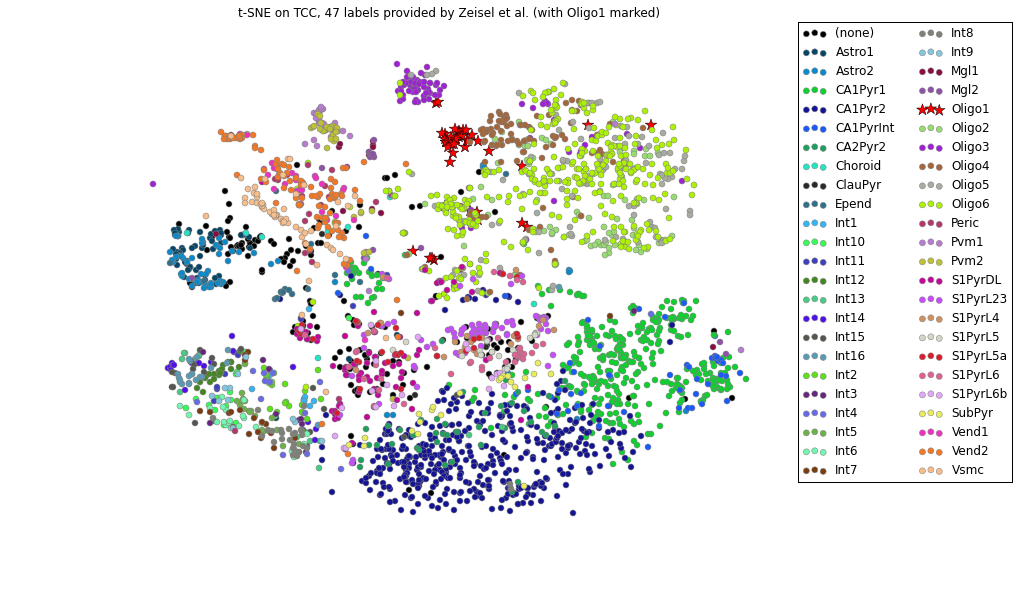

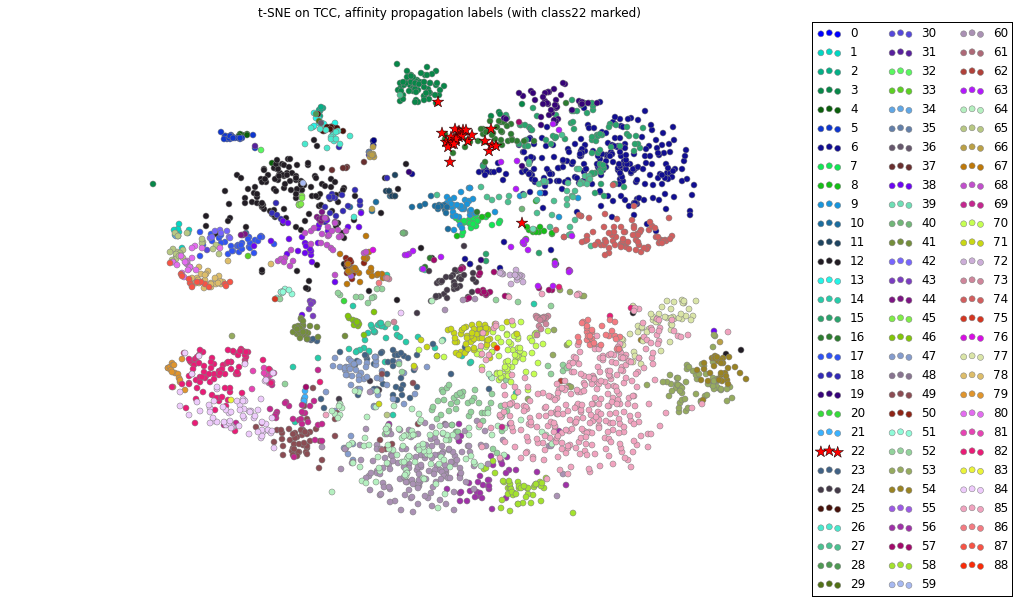

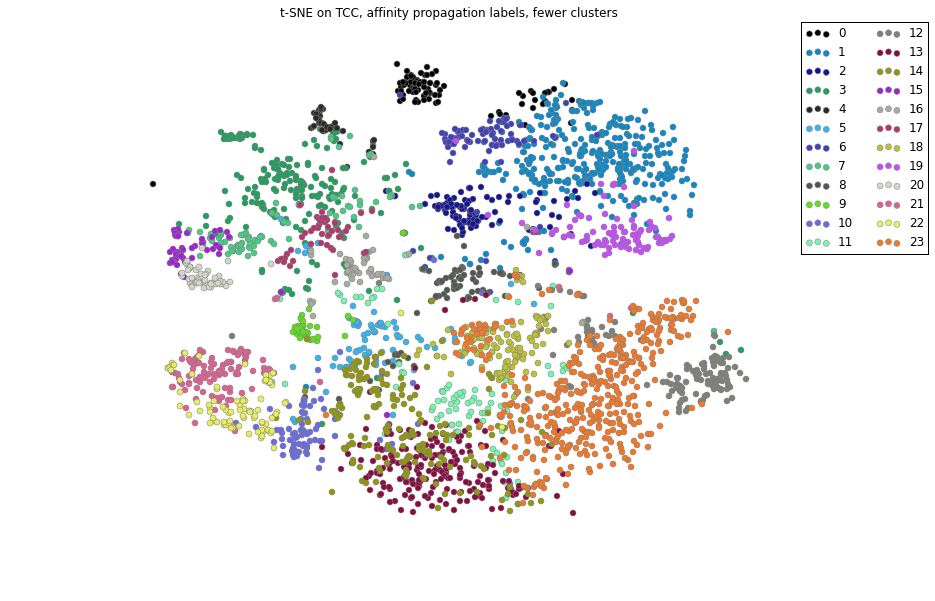

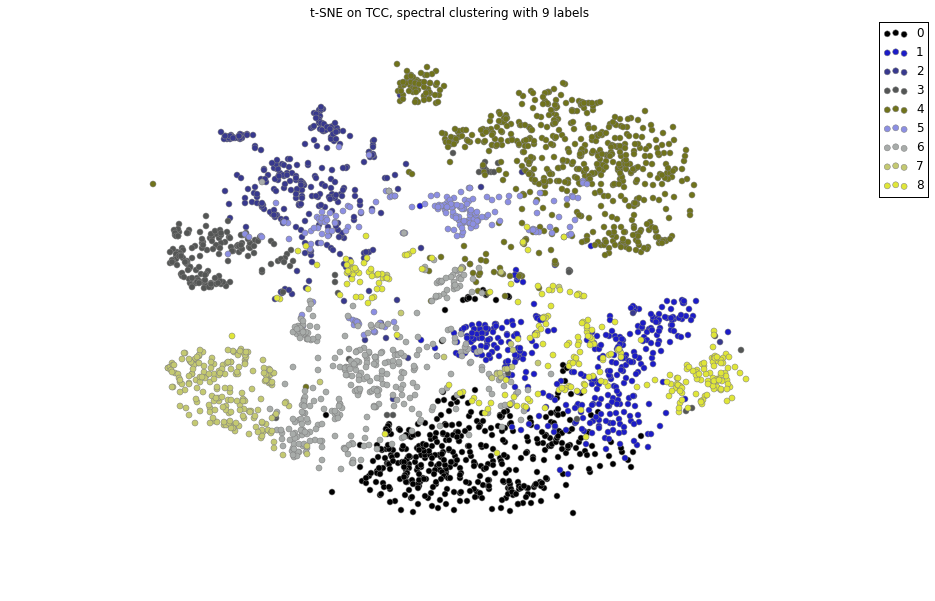

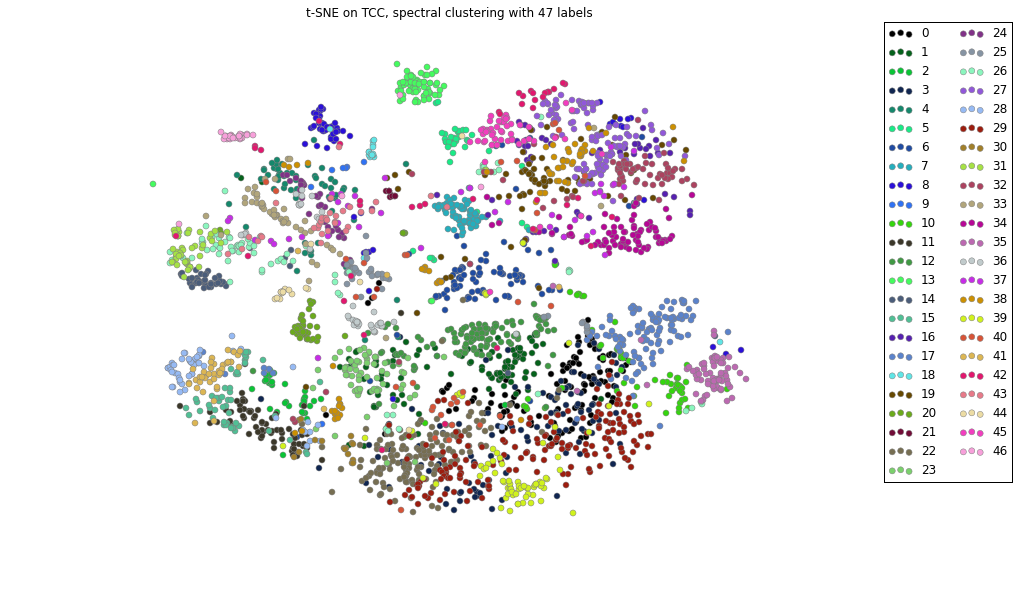

In [5]:
# Plot function with (nonrandom) colors corresponding to labels (stain plots stars in a specific label)
def stain_plot(X,labels,stain):
    unique_labels = np.unique(labels)
    N = len(unique_labels)
    max_value = 16581375 #255**3
    interval = int(max_value / N)
    colors = [hex(I)[2:].zfill(6) for I in range(0, max_value, interval)]    
    color= [(int(i[:2], 16)/float(255), int(i[2:4], 16)/float(255), int(i[4:], 16)/float(255)) for i in colors]
    i=0;
    plt.figure(figsize=(15,10))
    for label in unique_labels:
        ind = np.squeeze(labels == label)
        if label in stain: 
            plt.scatter(X[ind,0],X[ind,1],c='red',s=146,edgecolors='black',lw = 0.5, alpha=1,marker='*',label=label)
        else:
            plt.scatter(X[ind,0],X[ind,1],c=color[i],s=36,edgecolors='gray',lw = 0.5,label=label)        
        i=i+1   
        
labels47 = np.loadtxt('./Zeisels_data/Zeisels_labels47.txt',dtype=str)
stain_plot(X_tsne,labels47,['Oligo1'])
plt.title('t-SNE on TCC, 47 labels provided by Zeisel et al. (with Oligo1 marked)')
plt.legend(loc='upper right',bbox_to_anchor=(1.18, 1.01),ncol=2)
plt.xlim([-20,20])
plt.ylim([-20,20])
plt.axis('off')

        
stain_plot(X_tsne,tcc_affinity_labels1,[22])
plt.title('t-SNE on TCC, affinity propagation labels (with class22 marked)')
plt.legend(loc='upper right',bbox_to_anchor=(1.18, 1.01),ncol=3)
plt.xlim([-20,20])
plt.ylim([-20,20])
plt.axis('off')

stain_plot(X_tsne,tcc_affinity_labels2,[])
plt.title('t-SNE on TCC, affinity propagation labels, fewer clusters')
plt.legend(loc='upper right',bbox_to_anchor=(1.08, 1.01),ncol=2)
plt.xlim([-20,20])
plt.ylim([-20,20])
plt.axis('off')

stain_plot(X_tsne,tcc_spectral_labels9,[])
plt.title('t-SNE on TCC, spectral clustering with 9 labels')
plt.legend(loc='upper right',bbox_to_anchor=(1.08, 1.01),ncol=1)
plt.xlim([-20,20])
plt.ylim([-20,20])
plt.axis('off')


stain_plot(X_tsne,tcc_spectral_labels47,[])
plt.title('t-SNE on TCC, spectral clustering with 47 labels')
plt.legend(loc='upper right',bbox_to_anchor=(1.18, 1.01),ncol=2)
plt.xlim([-20,20])
plt.ylim([-20,20])
plt.axis('off')


## Temporary: Load Data


In [1]:
import pickle
import numpy as np

path_to_data = "/data/SS_RNA_seq/Code/clustering_on_reads/Zeisel_pipeline/"
path_to_metadata = "/data/SS_RNA_seq/Code/clustering_on_reads/Zeisel_pipeline/metadata/"

In [2]:
# Load transcript-compatibility counts
with open(path_to_data+'Zeisel_TCC_distribution_subsample100_full.dat', 'rb') as infile:
    X = pickle.load(infile)
        
with open(path_to_data+'Zeisel_TCC_distribution_wUMI_subsample100_full.dat', 'rb') as infile:
    X_umi_100 = pickle.load(infile)
with open(path_to_data+'Zeisel_TCC_distribution_wUMI_subsample10_full.dat', 'rb') as infile:
    X_umi_10 = pickle.load(infile)  
with open(path_to_data+'Zeisel_TCC_distribution_wUMI_subsample5_full.dat', 'rb') as infile:
    X_umi_5 = pickle.load(infile)
with open(path_to_data+'Zeisel_TCC_distribution_wUMI_subsample1_full.dat', 'rb') as infile:
    X_umi_1 = pickle.load(infile)
with open(path_to_data+'Zeisel_TCC_distribution_wUMI_subsample_point5_full.dat', 'rb') as infile:
    X_umi_p5 = pickle.load(infile)
with open(path_to_data+'Zeisel_TCC_distribution_wUMI_subsample_point1_full.dat', 'rb') as infile:
    X_umi_p1 = pickle.load(infile)

# Load precomputed jensen_shannon distance matrices
with open(path_to_data+'Zeisel_TCC_pairwise_JS_distance_subsample100_full.dat', 'rb') as infile:
    D = pickle.load(infile)  
    
with open(path_to_data+'Zeisel_TCC_pairwise_JS_distance_wUMI_subsample100_full.dat', 'rb') as infile:
    D_umi_100 = pickle.load(infile)  
with open(path_to_data+'Zeisel_TCC_pairwise_JS_distance_wUMI_subsample10_full.dat', 'rb') as infile:
    D_umi_10 = pickle.load(infile)  
with open(path_to_data+'Zeisel_TCC_pairwise_JS_distance_wUMI_subsample5_full.dat', 'rb') as infile:
    D_umi_5 = pickle.load(infile)  
with open(path_to_data+'Zeisel_TCC_pairwise_JS_distance_wUMI_subsample1_full.dat', 'rb') as infile:
    D_umi_1 = pickle.load(infile)  
with open(path_to_data+'Zeisel_TCC_pairwise_JS_distance_wUMI_subsample_point5_full.dat', 'rb') as infile:
    D_umi_p5 = pickle.load(infile)
with open(path_to_data+'Zeisel_TCC_pairwise_JS_distance_wUMI_subsample_point1_full.dat', 'rb') as infile:
    D_umi_p1 = pickle.load(infile)
 


### Load metadata ###

# load Zeisel et al. metadata      
cell_IDs = np.loadtxt(path_to_metadata+'cell_ID_as_in_gene_matrix.txt',dtype=str)
truth_9 = np.loadtxt(path_to_metadata+'truth_labels_9.txt',dtype=str)
truth_47 = np.loadtxt(path_to_metadata+'truth_labels_47.txt',dtype=str)
truth_tissue = np.loadtxt(path_to_metadata+'truth_cell_tissue.txt',dtype=str)
Cell_SRRs = np.loadtxt(path_to_metadata+'Cell_SRR_list.txt',dtype=str)
zeisel_g_names = np.loadtxt(path_to_metadata+'genenames_zeisel_order.txt',dtype=str)


#load Zeisel et al. gene expression matrix
with open(path_to_data+'Zeisel_gene_expression_matrix_DENSE.dat', 'rb') as infile:
    X_gene = pickle.load(infile) 
sorted_indices = np.argsort(cell_IDs)
X_gene_srt = X_gene[sorted_indices,:]   


#load the tSNE that was used in the paper
with open(path_to_data+'saved_tSNE.dat', 'rb') as infile:
    X_tsne = pickle.load(infile) 